# Refinery Yield Data Preprocessing (2006+)

This notebook preprocesses EIA refinery yield data for time series forecasting.  
Only data from 2006 onwards will be used!  
Works on data created by eia_query_builder.py in .../eia/preprocessing/scripts

In [221]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

In [222]:
# Preprocessing function definitions
# These functions are designed to be reusable and potentially integrated into RTDIP

def filter_to_mbbl_and_exclude_aggregates(df: pd.DataFrame, units_col: str = 'units', 
                                          duoarea_col: str = 'duoarea') -> pd.DataFrame:
    """
    Filter EIA refinery data to MBBL units only and exclude aggregate regions.
    
    Args:
        df: DataFrame with EIA refinery yield data
        units_col: Column name containing units (e.g., 'MBBL', 'MBBL/D')
        duoarea_col: Column name containing region codes
    
    Returns:
        Filtered DataFrame with only MBBL data and non-aggregate regions
    """
    df_filtered = df[df[units_col] == 'MBBL'].copy()
    # Exclude NUS (National U.S. total - it's sum of PADDs, causes data leakage)
    df_filtered = df_filtered[df_filtered[duoarea_col] != 'NUS'].copy()
    return df_filtered


def select_time_series_columns(df: pd.DataFrame, 
                               keep_cols: list = None) -> pd.DataFrame:
    """
    Select only essential columns for time series forecasting.
    
    Args:
        df: DataFrame with raw EIA data
        keep_cols: List of columns to keep. If None, uses default set.
    
    Returns:
        DataFrame with only essential time series columns
    """
    if keep_cols is None:
        keep_cols = ['period', 'duoarea', 'product', 'value']
    
    return df[keep_cols].copy()


def add_calendar_features(df: pd.DataFrame, datetime_col: str = 'period') -> pd.DataFrame:
    """
    Add basic calendar features (year, month) from datetime column.
    Designed for monthly time series data.
    
    Args:
        df: DataFrame with datetime column
        datetime_col: Name of datetime column
    
    Returns:
        DataFrame with added year and month columns
    """
    df_out = df.copy()
    df_out['year'] = df_out[datetime_col].dt.year
    df_out['month'] = df_out[datetime_col].dt.month
    return df_out


def add_cyclical_month_encoding(df: pd.DataFrame, month_col: str = 'month') -> pd.DataFrame:
    """
    Add cyclical encoding of months using sine/cosine transformation.
    This captures the cyclical nature where December (12) is close to January (1).
    
    Args:
        df: DataFrame with month column (1-12)
        month_col: Name of month column
    
    Returns:
        DataFrame with added month_sin and month_cos columns
    """
    df_out = df.copy()
    df_out['month_sin'] = np.sin(2 * np.pi * df_out[month_col] / 12)
    df_out['month_cos'] = np.cos(2 * np.pi * df_out[month_col] / 12)
    return df_out


def add_lag_features_by_group(df: pd.DataFrame, 
                              value_col: str = 'value',
                              group_cols: list = None,
                              lags: list = None) -> pd.DataFrame:
    """
    Add lagged values for each time series group (e.g., per duoarea-product).
    Essential for tree-based models like XGBoost that can't look back in time.
    
    Args:
        df: DataFrame sorted by time within groups
        value_col: Column to create lags from
        group_cols: Columns defining separate time series. If None, uses ['duoarea', 'product']
        lags: List of lag periods. If None, uses [1, 2, 3, 6, 12]
    
    Returns:
        DataFrame with added lag_N columns
    """
    if group_cols is None:
        group_cols = ['duoarea', 'product']
    if lags is None:
        lags = [1, 2, 3, 6, 12]
    
    df_out = df.copy()
    for lag in lags:
        df_out[f'lag_{lag}'] = df_out.groupby(group_cols)[value_col].shift(lag)
    
    return df_out


def add_rolling_statistics_by_group(df: pd.DataFrame,
                                    value_col: str = 'value',
                                    group_cols: list = None,
                                    windows: list = None,
                                    statistics: list = None) -> pd.DataFrame:
    """
    Add rolling window statistics for each time series group.
    Useful for capturing trends and volatility patterns.
    
    Args:
        df: DataFrame sorted by time within groups
        value_col: Column to calculate statistics from
        group_cols: Columns defining separate time series. If None, uses ['duoarea', 'product']
        windows: List of window sizes (in periods). If None, uses [3, 6, 12]
        statistics: List of statistics to compute. If None, uses ['mean', 'std', 'max', 'min']
    
    Returns:
        DataFrame with added rolling_STAT_WINDOW columns
    """
    if group_cols is None:
        group_cols = ['duoarea', 'product']
    if windows is None:
        windows = [3, 6, 12]
    if statistics is None:
        statistics = ['mean', 'std', 'max', 'min']
    
    df_out = df.copy()
    
    for window in windows:
        for stat in statistics:
            col_name = f'rolling_{stat}_{window}'
            
            if stat == 'mean':
                df_out[col_name] = df_out.groupby(group_cols)[value_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean()
                )
            elif stat == 'std':
                df_out[col_name] = df_out.groupby(group_cols)[value_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).std()
                )
            elif stat == 'max':
                df_out[col_name] = df_out.groupby(group_cols)[value_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).max()
                )
            elif stat == 'min':
                df_out[col_name] = df_out.groupby(group_cols)[value_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).min()
                )
    
    return df_out


def sort_by_datetime(df: pd.DataFrame, datetime_col: str, ascending: bool = True) -> pd.DataFrame:
    """
    Sort DataFrame by datetime column in chronological order.
    Adapted from Shell preprocessing pipeline.
    
    Args:
        df: DataFrame to sort
        datetime_col: Name of datetime column to sort by
        ascending: Sort in ascending order (default True for chronological)
    
    Returns:
        Sorted DataFrame with reset index
    """
    if datetime_col not in df.columns:
        raise KeyError(f"Column '{datetime_col}' not found in DataFrame.")
    
    df_sorted = df.copy()
    df_sorted = df_sorted.sort_values(
        by=datetime_col, 
        ascending=ascending,
        na_position='last'
    )
    df_sorted = df_sorted.reset_index(drop=True)
    
    return df_sorted


def validate_eia_data_quality(df: pd.DataFrame) -> dict:
    """
    Comprehensive data quality validation for EIA refinery yield data.
    Adapted from Shell preprocessing pipeline for EIA-specific checks.
    
    Args:
        df: Preprocessed EIA DataFrame
    
    Returns:
        Dictionary with validation status, issues, warnings, and statistics
    """
    print("=" * 80)
    print("DATA QUALITY VALIDATION")
    print("=" * 80)
    
    issues = []
    warnings = []
    
    # 1. Check for missing values
    print("\n1. Missing Values Check:")
    missing_counts = df.isnull().sum()
    missing_cols = missing_counts[missing_counts > 0]
    
    if len(missing_cols) > 0:
        print(f"  Found missing values in {len(missing_cols)} columns:")
        for col, count in missing_cols.items():
            pct = count / len(df) * 100
            print(f"    {col}: {count:,} ({pct:.2f}%)")
            
            # Critical if missing in key columns
            if col in ['period', 'duoarea', 'product'] and count > 0:
                issues.append(f"Missing values in key column '{col}': {count:,}")
            elif col == 'value' and count > 0:
                warnings.append(f"Missing values in target 'value': {count:,} ({pct:.2f}%)")
    else:
        print(f"No missing values")
    
    # 2. Check for infinite values
    print("\n2. Infinite Values Check:")
    numeric_cols = df.select_dtypes(include=['float64', 'int32', 'int64']).columns
    inf_count = 0
    for col in numeric_cols:
        inf_in_col = np.isinf(df[col]).sum()
        if inf_in_col > 0:
            inf_count += inf_in_col
            issues.append(f"Column '{col}' has {inf_in_col:,} infinite values")
            print(f"  ⚠️  {col}: {inf_in_col:,} infinite values")
    
    if inf_count == 0:
        print(f"No infinite values")
    
    # 3. Check data types
    print("\n3. Data Type Check:")
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Expected object columns (before encoding)
    expected_objects = ['duoarea', 'product']
    unexpected_objects = [col for col in object_cols if col not in expected_objects]
    
    if len(unexpected_objects) > 0:
        print(f"  ⚠️  {len(unexpected_objects)} unexpected object columns:")
        for col in unexpected_objects:
            print(f"    - {col}")
            warnings.append(f"Unexpected object column: '{col}'")
    else:
        print(f"All columns have appropriate numeric/datetime types")
    
    # 4. Check timestamp validity
    print("\n4. Timestamp Validity:")
    if 'period' in df.columns:
        nat_count = df['period'].isna().sum()
        if nat_count > 0:
            issues.append(f"Found {nat_count:,} NaT timestamps")
            print(f"  ⚠️  {nat_count:,} NaT timestamps")
        else:
            print(f"  ✓ All timestamps valid")
            min_date = df['period'].min()
            max_date = df['period'].max()
            print(f"    Date range: {min_date} to {max_date}")
            
            # Check if sorted
            is_sorted = df['period'].is_monotonic_increasing
            if not is_sorted:
                # Check if sorted within groups
                if 'duoarea' in df.columns and 'product' in df.columns:
                    group_sorted = df.groupby(['duoarea', 'product'])['period'].apply(
                        lambda x: x.is_monotonic_increasing
                    ).all()
                    if group_sorted:
                        print(f"    ✓ Sorted within duoarea-product groups")
                    else:
                        warnings.append("Not sorted within groups")
                        print(f"    ⚠️  NOT sorted within groups")
                else:
                    warnings.append("Timestamps not globally sorted")
                    print(f"    ⚠️  NOT sorted chronologically")
    
    # 5. Check target variable distribution
    print("\n5. Target Variable (value) Check:")
    if 'value' in df.columns:
        valid_values = df['value'].dropna()
        
        if len(valid_values) > 0:
            print(f"  Count: {len(valid_values):,}")
            print(f"  Range: {valid_values.min():.2f} to {valid_values.max():.2f} MBBL")
            print(f"  Mean: {valid_values.mean():.2f} MBBL")
            print(f"  Median: {valid_values.median():.2f} MBBL")
            
            # Check for negative values (legitimate in EIA data = net consumption)
            negative_count = (valid_values < 0).sum()
            if negative_count > 0:
                pct = negative_count / len(valid_values) * 100
                print(f"  Negative values: {negative_count:,} ({pct:.2f}%) - legitimate net consumption")
            
            # Check for zeros
            zero_count = (valid_values == 0).sum()
            if zero_count > 0:
                pct = zero_count / len(valid_values) * 100
                print(f"  Zero values: {zero_count:,} ({pct:.2f}%)")
        else:
            issues.append("No valid values found in 'value' column")
    
    # 6. Check encoded features (if present)
    print("\n6. Encoded Features Check:")
    encoded_cols = [col for col in df.columns if '_encoded' in col]
    if encoded_cols:
        for col in encoded_cols:
            unique_count = df[col].nunique()
            val_range = (df[col].min(), df[col].max())
            print(f"  {col}: {unique_count} unique values, range {val_range}")
    else:
        print(f"  No encoded features found (run encoding step)")
    
    # 7. Check for duplicate rows
    print("\n7. Duplicate Rows Check:")
    if 'period' in df.columns and 'duoarea' in df.columns and 'product' in df.columns:
        duplicates = df.duplicated(subset=['period', 'duoarea', 'product'], keep=False).sum()
        if duplicates > 0:
            issues.append(f"Found {duplicates:,} duplicate rows (same period-duoarea-product)")
            print(f"  ⚠️  {duplicates:,} duplicate rows")
        else:
            print(f"  ✓ No duplicates")
    
    # 8. Memory usage
    print("\n8. Memory Usage:")
    memory_mb = df.memory_usage(deep=True).sum() / 1024 / 1024
    print(f"  Total memory: {memory_mb:.2f} MB ({memory_mb/1024:.2f} GB)")
    
    # Summary
    print("\n" + "=" * 80)
    print("VALIDATION SUMMARY")
    print("=" * 80)
    
    if len(issues) == 0 and len(warnings) == 0:
        print("✓ All checks passed - data ready for modeling")
        status = "READY"
    elif len(issues) == 0:
        print(f"✓ No critical issues found")
        print(f"⚠️  {len(warnings)} warning(s):")
        for warning in warnings:
            print(f"  - {warning}")
        status = "READY_WITH_WARNINGS"
    else:
        print(f"⚠️  Found {len(issues)} critical issue(s):")
        for issue in issues:
            print(f"  - {issue}")
        if len(warnings) > 0:
            print(f"⚠️  Additional {len(warnings)} warning(s):")
            for warning in warnings:
                print(f"  - {warning}")
        status = "NEEDS_ATTENTION"
    
    print("=" * 80)
    
    return {
        'status': status,
        'issues': issues,
        'warnings': warnings,
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'memory_mb': memory_mb
    }

def one_hot_encode(df: pd.DataFrame,column: str,sparse: bool = False)-> pd.DataFrame:
    return pd.get_dummies(df, columns=[column], sparse=sparse)

## 1. Setup and Load Data

In [223]:
# Load data
DATA_DIR = Path("/workspaces/amos2025ws03-rtdip-timeseries-forecasting/amos_team_resources/eia/exploration/data/raw")

# Find most recent data folder (2006+ data)
data_folders = sorted([f for f in DATA_DIR.glob("v2_petroleum_pnp_refp2_data_*")])
if data_folders:
    latest_folder = data_folders[-1]
    JSON_PATH = latest_folder / "merged.json"
    print(f"Using data from: {latest_folder.name}")
else:
    raise FileNotFoundError("No data folder found!")

with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

ds_data = data["response"]["data"]
print(f"Loaded {len(ds_data):,} records")

Using data from: v2_petroleum_pnp_refp2_data_20251116_223203
Loaded 100,000 records


In [224]:
# Create DataFrame
df_raw = pd.DataFrame(ds_data)

print(f"Shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")
df_raw.head()

Shape: (100000, 11)

Columns: ['period', 'duoarea', 'area-name', 'product', 'product-name', 'process', 'process-name', 'series', 'series-description', 'value', 'units']


,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2006-12,R20,PADD 2,EPDM10,"Distillate Fuel Oil, Greater than 15 to 500 pp...",YPY,Refinery Net Production,MD1RX_R20_2,Midwest (PADD 2) Refinery Net Production of Di...,148,MBBL/D
1,2006-12,REC,NA,EPD00H,"Distillate Fuel Oil, Greater Than 500 ppm Sulfur",YPY,Refinery Net Production,MDGRX_REC_1,Refining District East Coast Refinery Net Prod...,6644,MBBL
2,2006-12,R2C,NA,EPD00H,"Distillate Fuel Oil, Greater Than 500 ppm Sulfur",YPY,Refinery Net Production,MDGRX_R2C_2,Refining District Oklahoma-Kansas-Missouri Ref...,22,MBBL/D
3,2006-12,R2A,NA,EPD00H,"Distillate Fuel Oil, Greater Than 500 ppm Sulfur",YPY,Refinery Net Production,MDGRX_R2A_2,Refining District Indiana-Illinois-Kentucky Re...,32,MBBL/D
4,2006-12,R30,PADD 3,EPD0,Distillate Fuel Oil,YPY,Refinery Net Production,MDIRX_R30_2,Gulf Coast (PADD 3) Refinery Net Production of...,2004,MBBL/D


## 2. Data Quality Investigation

In [225]:
# Convert data types
df = df_raw.copy()
df['period'] = pd.to_datetime(df['period'], errors='coerce')
df['value'] = pd.to_numeric(df['value'], errors='coerce')

print(f"Total records: {len(df):,}")
print(f"Date range: {df['period'].min()} to {df['period'].max()}")
print(f"\nUnique counts:")
for col in ['duoarea', 'area-name', 'product', 'units']:
    print(f"  {col:15s}: {df[col].nunique():>5,}")

print(f"\nMissing values in 'value' column: {df['value'].isna().sum():,} ({100*df['value'].isna().mean():.2f}%)")

Total records: 100,000
Date range: 2006-09-01 00:00:00 to 2025-07-01 00:00:00

Unique counts:
  duoarea        :    16
  area-name      :     7
  product        :    56
  units          :     2

Missing values in 'value' column: 2,051 (2.05%)


In [226]:
# Check duoarea to area-name mapping (should be 1-to-1)
mapping = df[['duoarea', 'area-name']].drop_duplicates().sort_values('duoarea')
print("Duoarea to Region Mapping:")
print(mapping.to_string(index=False))
print("\nEach duoarea maps to exactly ONE region")

Duoarea to Region Mapping:
duoarea area-name
    NUS      U.S.
    R10    PADD 1
    R20    PADD 2
    R2A        NA
    R2B        NA
    R2C        NA
    R30    PADD 3
    R3A        NA
    R3B        NA
    R3C        NA
    R3D        NA
    R3E        NA
    R40    PADD 4
    R50    PADD 5
    RAP        NA
    REC        NA

Each duoarea maps to exactly ONE region


In [227]:
# Check ALL areas - which months have data?
df_mbbl = df[df['units'] == 'MBBL'].copy()

all_areas = df_mbbl['duoarea'].unique()

print("=" * 100)
print("WHICH MONTHS HAVE DATA FOR ALL Areas?")
print("=" * 100)

for area in sorted(all_areas):
    # Get all months with ANY product data for this area
    ref_data = df_mbbl[df_mbbl['duoarea'] == area]
    months_with_data = sorted(ref_data['period'].unique())
    
    if len(months_with_data) == 0:
        print(f"\n{area}: NO DATA")
        continue
    
    print(f"\n{area}:")
    print(f"  Total months with data: {len(months_with_data)}")
    print(f"  Date range: {months_with_data[0].strftime('%Y-%m')} to {months_with_data[-1].strftime('%Y-%m')}")
    
    # Count by month number to find pattern
    month_counts = {}
    for date in months_with_data:
        month_num = date.month
        month_counts[month_num] = month_counts.get(month_num, 0) + 1
    
    # Show which calendar months appear
    print(f"  Months that appear (Jan=1, Dec=12):")
    calendar = []
    for m in range(1, 13):
        if m in month_counts:
            calendar.append(f"{m:2d}✓({month_counts[m]:2d})")
        else:
            calendar.append(f"{m:2d}✗")
    
    print(f"    {' '.join(calendar[:6])}")
    print(f"    {' '.join(calendar[6:])}")

WHICH MONTHS HAVE DATA FOR ALL Areas?

NUS:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)

R10:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)

R20:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)



R2A:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)

R2B:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)

R2C:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)

R30:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)

R3A:
  Total months with data: 80
  Date range: 2006-09 to 2025-07
  Months that appear (Jan=1, Dec=12):
     1✗  2✗  3✗  4✓( 1)  5✓( 1)  6✓( 1)
     7✓( 1)  8✗  9✓(19) 10✓(19) 11✓(19) 12✓(19)

R3B:
  Total months with data

In [228]:
# Check product reporting completeness within Sep-Dec
df_mbbl = df[df['units'] == 'MBBL'].copy()

# Filter to Sep-Dec only (the months we know exist)
df_reporting_months = df_mbbl[df_mbbl['period'].dt.month.isin([9, 10, 11, 12])].copy()

print("=" * 100)
print("PRODUCT COMPLETENESS CHECK (Sep-Dec months only)")
print("=" * 100)

for area in ['NUS', 'R10', 'R20', 'R30', 'R40', 'R50', 'R3B']:
    ref_data = df_reporting_months[df_reporting_months['duoarea'] == area]
    
    if len(ref_data) == 0:
        continue
    
    print(f"\n{area}:")
    
    # Get all unique products for this area
    products = ref_data['product'].unique()
    print(f"  Total unique products: {len(products)}")
    
    # For each product, check how many Sep-Dec months it appears in
    product_completeness = []
    
    for product in products:
        prod_data = ref_data[ref_data['product'] == product]
        months_reported = len(prod_data)
        unique_months = prod_data['period'].nunique()
        
        # Expected: ~19 years * 4 months = 76 months max
        product_completeness.append({
            'product': product,
            'months_reported': unique_months,
            'completeness_%': 100 * unique_months / 76 if 76 > 0 else 0
        })
    
    # Show top 10 most complete and bottom 10 least complete
    prod_df = pd.DataFrame(product_completeness).sort_values('completeness_%', ascending=False)
    
    print(f"  Most complete products:")
    for _, row in prod_df.head(5).iterrows():
        print(f"    {row['product']}: {row['months_reported']}/76 months ({row['completeness_%']:.1f}%)")
    
    print(f"  Least complete products:")
    for _, row in prod_df.tail(5).iterrows():
        print(f"    {row['product']}: {row['months_reported']}/76 months ({row['completeness_%']:.1f}%)")

PRODUCT COMPLETENESS CHECK (Sep-Dec months only)

NUS:
  Total unique products: 56
  Most complete products:
    EPM0F: 75/76 months (98.7%)
    EPDM10: 75/76 months (98.7%)
    EPDXL0: 74/76 months (97.4%)
    EPJKC: 74/76 months (97.4%)
    EPPRH: 73/76 months (96.1%)
  Least complete products:
    EPM0CAL55: 56/76 months (73.7%)
    EPPMF: 52/76 months (68.4%)
    EPL2: 51/76 months (67.1%)
    EPM0CAG55: 37/76 months (48.7%)
    EPM0RO: 11/76 months (14.5%)

R10:
  Total unique products: 49
  Most complete products:
    EPPK: 73/76 months (96.1%)
    EPPRH: 73/76 months (96.1%)
    EPJKC: 73/76 months (96.1%)
    EPLLB0I: 72/76 months (94.7%)
    EPLLBAI: 72/76 months (94.7%)
  Least complete products:
    EPM0CAL55: 54/76 months (71.1%)
    EPM0CA: 52/76 months (68.4%)
    EPPPN: 48/76 months (63.2%)
    EPLLBYI: 47/76 months (61.8%)
    EPPPO: 7/76 months (9.2%)

R20:
  Total unique products: 53
  Most complete products:
    EPLLB0I: 74/76 months (97.4%)
    EPPPN: 73/76 months (

- go with September to December only and dont use products for granularity -> 
- In practice we should probably filter out rare products, but our models will never go into production, so we only test on existing rows
- **→ Just use all data we have for the model**
- **IN ORDER TO AVOID NANS COMPLETELY WE WON`T BE ABLE TO USE TIME SERIES FEATURES (LAG,...) THOUGH**

In [229]:
# Check if NUS is an aggregate of other duoareas
# NUS = National U.S., might be sum of all PADD regions

test_month = '2015-12-01'
test_product = 'EPJKM'

test_data = df_mbbl[(df_mbbl['period'] == test_month) & (df_mbbl['product'] == test_product)]

if len(test_data) > 0:
    nus_val = test_data[test_data['duoarea'] == 'NUS']['value'].iloc[0] if len(test_data[test_data['duoarea'] == 'NUS']) > 0 else 0
    
    # Sum of main PADDs (R10-R50)
    padds = test_data[test_data['duoarea'].isin(['R10', 'R20', 'R30', 'R40', 'R50'])]
    padds_sum = padds['value'].sum()
    
    print(f"Testing if NUS is aggregate: {test_product} in {test_month}")
    print(f"NUS value: {nus_val:,.0f} MBBL")
    print(f"Sum of PADDs (R10-R50): {padds_sum:,.0f} MBBL")
    print(f"Difference: {abs(nus_val - padds_sum):,.0f} MBBL")

Testing if NUS is aggregate: EPJKM in 2015-12-01
NUS value: 1,838 MBBL
Sum of PADDs (R10-R50): 1,838 MBBL
Difference: 0 MBBL


- NUS is TOTAL U.S. (aggregated)  
--> exclude and use subregions

VALUE DISTRIBUTION (MBBL only):

Basic stats:
  Count: 48,930
  Mean: 4858.94
  Median: 469.00
  Std: 20690.38
  Min: -37527.00
  Max: 462377.00

Negative values: 6490 (13.26%)
Zero values: 132 (0.27%)

Outliers (3×IQR):
  High (>10172): 4776 (9.76%)
  Low (<-7559): 264 (0.54%)


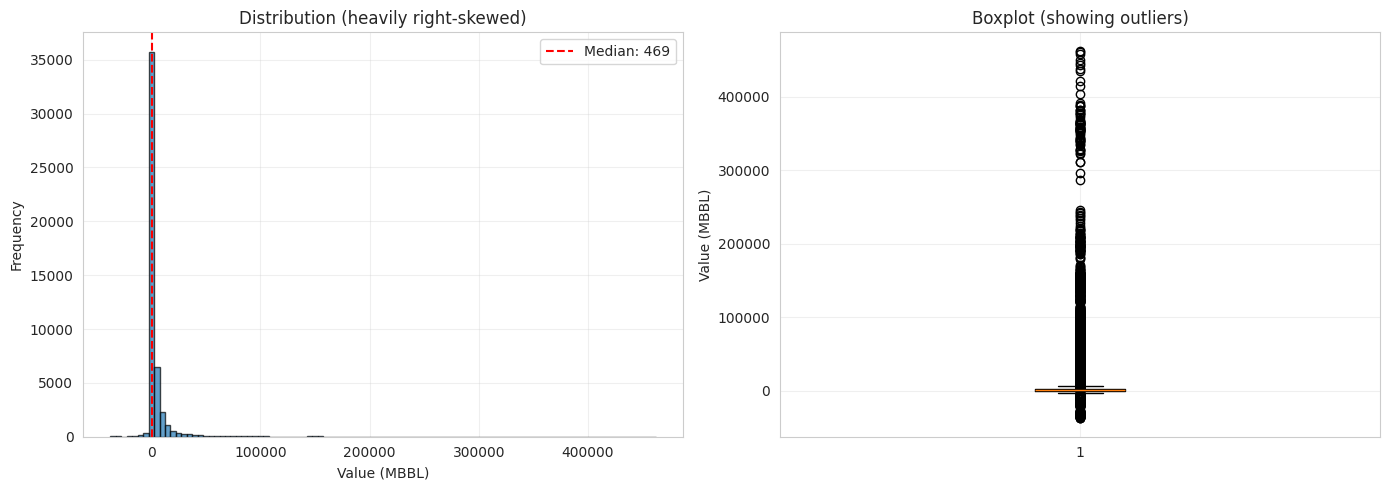

In [230]:
# Check value distribution and outliers
values_clean = df_mbbl['value'].dropna()

print("VALUE DISTRIBUTION (MBBL only):")
print(f"\nBasic stats:")
print(f"  Count: {len(values_clean):,}")
print(f"  Mean: {values_clean.mean():.2f}")
print(f"  Median: {values_clean.median():.2f}")
print(f"  Std: {values_clean.std():.2f}")
print(f"  Min: {values_clean.min():.2f}")
print(f"  Max: {values_clean.max():.2f}")

# Check for negative and zero values
negative_count = (values_clean < 0).sum()
zero_count = (values_clean == 0).sum()
print(f"\nNegative values: {negative_count} ({100*negative_count/len(values_clean):.2f}%)")
print(f"Zero values: {zero_count} ({100*zero_count/len(values_clean):.2f}%)")

# Outlier detection
Q1 = values_clean.quantile(0.25)
Q3 = values_clean.quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_high = Q3 + 3 * IQR
outlier_threshold_low = Q1 - 3 * IQR

outliers_high = (values_clean > outlier_threshold_high).sum()
outliers_low = (values_clean < outlier_threshold_low).sum()

print(f"\nOutliers (3×IQR):")
print(f"  High (>{outlier_threshold_high:.0f}): {outliers_high} ({100*outliers_high/len(values_clean):.2f}%)")
print(f"  Low (<{outlier_threshold_low:.0f}): {outliers_low} ({100*outliers_low/len(values_clean):.2f}%)")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(values_clean, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Value (MBBL)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution (heavily right-skewed)')
axes[0].axvline(values_clean.median(), color='red', linestyle='--', label=f'Median: {values_clean.median():.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(values_clean, vert=True)
axes[1].set_ylabel('Value (MBBL)')
axes[1].set_title('Boxplot (showing outliers)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [231]:
# Investigate negative values
negatives = df_mbbl[df_mbbl['value'] < 0]

print("INVESTIGATING NEGATIVE VALUES:")
print(f"Total: {len(negatives)}\n")

print("By product (top 10):")
print(negatives.groupby('product')['value'].agg(['count', 'min']).sort_values('count', ascending=False).head(10))

print(f"\nBy year:")
print(negatives.groupby(negatives['period'].dt.year)['value'].count())



INVESTIGATING NEGATIVE VALUES:
Total: 6490

By product (top 10):
         count      min
product                
EPPG      1101 -37527.0
EPLLBAN    925  -8534.0
EPLLB0N    799  -8845.0
EPLLBAI    738  -1197.0
EPLLB0I    564  -1012.0
EPLLBYN    549   -706.0
EPL2       314  -1584.0
EPD00H     239   -629.0
EPL0       192   -725.0
EPLL       169   -725.0

By year:
period
2006    273
2007    279
2008    277
2009    304
2010    330
2011    327
2012    364
2013    385
2014    329
2015    361
2016    363
2017    375
2018    360
2019    372
2020    425
2021    391
2022    245
2023    270
2024    273
2025    187
Name: value, dtype: int64


- leave them in or not?   
--> is consistend across time, products, refineries   
--> might be actual data instead of errors   
--> keep it

In [232]:
# Check if 'series' column is deterministic (just a combination of other columns)
unique_series_per_combo = df.groupby(['duoarea', 'product', 'process', 'units'])['series'].nunique()
max_series = unique_series_per_combo.max()

print(f"\nMax different 'series' values for same duoarea+product+process+units: {max_series}")
if max_series == 1:
    print("'series' is deterministic")


Max different 'series' values for same duoarea+product+process+units: 1
'series' is deterministic


--> dont need series

## 3. Filter and Prepare Time Series Data

In [233]:
# Filter to MBBL and exclude NUS (National U.S. aggregate)
df_clean = filter_to_mbbl_and_exclude_aggregates(df)

print(f"After filtering:")
print(f"  Records: {len(df_clean):,}")
print(f"  Duoareas: {df_clean['duoarea'].nunique()}")
print(f"  Products: {df_clean['product'].nunique()}")
print(f"  Date range: {df_clean['period'].min()} to {df_clean['period'].max()}")

After filtering:
  Records: 45,999
  Duoareas: 15
  Products: 56
  Date range: 2006-09-01 00:00:00 to 2025-07-01 00:00:00


In [234]:
# Select essential columns and sort chronologically
df_ts = select_time_series_columns(df_clean, keep_cols=['period', 'duoarea', 'product', 'value'])
df_ts = sort_by_datetime(df_ts, datetime_col='period', ascending=True)

print(f"Time series data shape: {df_ts.shape}")
print(f"Unique series (area × product): {df_ts.groupby(['duoarea', 'product']).ngroups:,}")
df_ts.head(10)

Time series data shape: (45999, 4)
Unique series (area × product): 721


,period,duoarea,product,value
0,2006-09-01,RAP,EPLLPZ,27.0
1,2006-09-01,R2B,EPLLB0I,9.0
2,2006-09-01,R20,EPLLB0I,137.0
3,2006-09-01,R40,EPLL,232.0
4,2006-09-01,R3E,EPJKM,59.0
5,2006-09-01,R2B,EPJKC,820.0
6,2006-09-01,R3E,EPJK,59.0
7,2006-09-01,R2B,EPJK,866.0
8,2006-09-01,R20,EPDXL0,19655.0
9,2006-09-01,R3A,EPDXL0,4802.0


## 4. Feature Engineering

In [235]:
# Add calendar features (year, month, month_sin, month_cos)
df_ts = add_calendar_features(df_ts, datetime_col='period')
df_ts = add_cyclical_month_encoding(df_ts, month_col='month') # should drop month or this before training 


- Inconsistent and missing data  
--> **IF WE WANT TO AVOID NANS COMPLETELY WE WON`T BE ABLE TO USE TIME SERIES FEATURES (LAG,...)**

- other option would have been working on duoarea grunalarity and not duoarea x product


In [236]:
# Add lag features and rolling statistics
# These are essential for tree-based models (XGBoost) that can't look back in time
"""
print("Adding lag features and rolling statistics...")

df_features = add_lag_features_by_group(
    df_ts, 
    value_col='value',
    group_cols=['duoarea', 'product'],
    lags=[1, 2, 3, 6, 12]
)

df_features = add_rolling_statistics_by_group(
    df_features,
    value_col='value', 
    group_cols=['duoarea', 'product'],
    windows=[3, 6, 12],
    statistics=['mean', 'std', 'max', 'min']
)

print(f"Total columns: {len(df_features.columns)}")
"""

'\nprint("Adding lag features and rolling statistics...")\n\ndf_features = add_lag_features_by_group(\n    df_ts, \n    value_col=\'value\',\n    group_cols=[\'duoarea\', \'product\'],\n    lags=[1, 2, 3, 6, 12]\n)\n\ndf_features = add_rolling_statistics_by_group(\n    df_features,\n    value_col=\'value\', \n    group_cols=[\'duoarea\', \'product\'],\n    windows=[3, 6, 12],\n    statistics=[\'mean\', \'std\', \'max\', \'min\']\n)\n\nprint(f"Total columns: {len(df_features.columns)}")\n'

In [237]:
# Encode categorical features using one-hot encoding
# Creates binary columns for each category (e.g., duoarea_R10, duoarea_R20, product_EP00, etc.)

print("One-hot encoding categorical features...")
df_features = df_ts
# Encode duoarea and product separately to keep track
df_features = one_hot_encode(df_features, column='duoarea', sparse=False)
df_features = one_hot_encode(df_features, column='product', sparse=False)

# Count the new columns
duoarea_cols = [col for col in df_features.columns if col.startswith('duoarea_')]
product_cols = [col for col in df_features.columns if col.startswith('product_')]

print(f"One-hot encoded duoarea: {len(duoarea_cols)} binary columns")
print(f"One-hot encoded product: {len(product_cols)} binary columns")
print(f"\nDuoarea columns (first 5): {duoarea_cols[:5]}")
print(f"Product columns (first 5): {product_cols[:5]}")
print(f"\nTotal columns: {len(df_features.columns)}")


One-hot encoding categorical features...
One-hot encoded duoarea: 15 binary columns
One-hot encoded product: 56 binary columns

Duoarea columns (first 5): ['duoarea_R10', 'duoarea_R20', 'duoarea_R2A', 'duoarea_R2B', 'duoarea_R2C']
Product columns (first 5): ['product_EP00', 'product_EPD0', 'product_EPD00H', 'product_EPDM10', 'product_EPDXL0']

Total columns: 77


- IF THIS ARE TOO MANY COLUMNS FOR MEMORY, TRY LABEL ENCODING

In [238]:
# Validate data types
print("Validating data types...")
print("\nCurrent dtypes:")
print(df_features.dtypes)

# Ensure correct types
df_features['period'] = pd.to_datetime(df_features['period'])
df_features['value'] = df_features['value'].astype('float64')
df_features['year'] = df_features['year'].astype('int32')
df_features['month'] = df_features['month'].astype('int32')

# Ensure all numeric features are float64
#numeric_cols = ['month_sin', 'month_cos']
numeric_cols = []

# Add lag and rolling feature columns if they exist
lag_cols = [col for col in df_features.columns if col.startswith('lag_')]
rolling_cols = [col for col in df_features.columns if col.startswith('rolling_')]
numeric_cols.extend(lag_cols + rolling_cols)

for col in numeric_cols:
    if col in df_features.columns:
        df_features[col] = df_features[col].astype('float64')

# One-hot encoded features are already uint8 (0 or 1) - no need to change
duoarea_cols = [col for col in df_features.columns if col.startswith('duoarea_')]
product_cols = [col for col in df_features.columns if col.startswith('product_')]

#print("\nData types validated")
#print(f"  datetime64[ns]: period")
#print(f"  float64: value, month_sin, month_cos, lag features ({len(lag_cols)}), rolling features ({len(rolling_cols)})")
#print(f"  int32: year, month")
#print(f"  uint8: one-hot encoded duoarea ({len(duoarea_cols)}), product ({len(product_cols)})")

Validating data types...

Current dtypes:
period           datetime64[ns]
value                   float64
year                      int32
month                     int32
month_sin               float64
                      ...      
product_EPPRX              bool
product_EPPRY              bool
product_EPPS               bool
product_EPPV               bool
product_EPPW               bool
Length: 77, dtype: object


In [239]:
# Check for missing values (from lag/rolling features)
print("Checking missing values in features...")

missing_summary = df_features.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print(f"\nColumns with missing values:")
    for col, count in missing_summary.items():
        pct = 100 * count / len(df_features)
        print(f"  {col:25s}: {count:>6,} ({pct:>5.2f}%)")
    
    # Show how many rows would be lost if we drop all NaN
    complete_rows = df_features.dropna().shape[0]
    total_rows = len(df_features)
    print(f"\nIf dropping all NaN rows: {total_rows - complete_rows:,} rows lost ({100*(total_rows-complete_rows)/total_rows:.2f}%)")

else:
    print("\nNo missing values found")

Checking missing values in features...

Columns with missing values:
  value                    :    943 ( 2.05%)

If dropping all NaN rows: 943 rows lost (2.05%)


In [240]:
# Remove rows with missing target values -> only small loss
df_features = df_features.dropna(subset=['value'])

In [241]:
# Create scaled version -> dont really need this for models like xgboost & lstm is not feasable here
"""
from sklearn.preprocessing import MinMaxScaler

print("Creating scaled features for LSTM/neural networks...")

# Copy to separate dataframe for LSTM
df_features_scaled = df_features.copy()

# Dynamically find features that need scaling
features_to_scale = []

# Scale year (wide range: 2006-2025, much larger than other features)
if 'year' in df_features.columns:
    features_to_scale.append('year')

# Scale any lag features (wide range of production values)
lag_cols = [col for col in df_features.columns if col.startswith('lag_')]
features_to_scale.extend(lag_cols)

# Scale any rolling features (wide range)
rolling_cols = [col for col in df_features.columns if col.startswith('rolling_')]
features_to_scale.extend(rolling_cols)

# Features that DON'T need scaling (already in good range):
# - month_sin, month_cos (already [-1, 1])
# - month (only 9-12, small range - not used in LSTM anyway)
# - duoarea_XXX, product_XXX (one-hot encoded, already 0/1)
# - value (target - never scale)

if len(features_to_scale) > 0:
    # Initialize scaler
    scaler = MinMaxScaler()
    
    # Scale features in the LSTM dataframe
    for col in features_to_scale:
        mask = df_features_scaled[col].notna()
        if mask.sum() > 0:
            df_features_scaled[f'{col}_scaled'] = scaler.fit_transform(
                df_features_scaled.loc[mask, [col]]
            )
    
    print(f"Scaled {len(features_to_scale)} features: {features_to_scale}")
else:
    print(f"No features need scaling")
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n\nprint("Creating scaled features for LSTM/neural networks...")\n\n# Copy to separate dataframe for LSTM\ndf_features_scaled = df_features.copy()\n\n# Dynamically find features that need scaling\nfeatures_to_scale = []\n\n# Scale year (wide range: 2006-2025, much larger than other features)\nif \'year\' in df_features.columns:\n    features_to_scale.append(\'year\')\n\n# Scale any lag features (wide range of production values)\nlag_cols = [col for col in df_features.columns if col.startswith(\'lag_\')]\nfeatures_to_scale.extend(lag_cols)\n\n# Scale any rolling features (wide range)\nrolling_cols = [col for col in df_features.columns if col.startswith(\'rolling_\')]\nfeatures_to_scale.extend(rolling_cols)\n\n# Features that DON\'T need scaling (already in good range):\n# - month_sin, month_cos (already [-1, 1])\n# - month (only 9-12, small range - not used in LSTM anyway)\n# - duoarea_XXX, product_XXX (one-hot encoded, already 0/1)\n# -

In [242]:
# Drop month or encoded version beofre training
df_features = df_features.drop(columns=["month"])

In [243]:
# Data quality validation 
validation_results = validate_eia_data_quality(df_features)

DATA QUALITY VALIDATION

1. Missing Values Check:
No missing values

2. Infinite Values Check:
No infinite values

3. Data Type Check:
All columns have appropriate numeric/datetime types

4. Timestamp Validity:
  ✓ All timestamps valid
    Date range: 2006-09-01 00:00:00 to 2025-07-01 00:00:00

5. Target Variable (value) Check:
  Count: 45,056
  Range: -21927.00 to 246418.00 MBBL
  Mean: 3406.72 MBBL
  Median: 401.00 MBBL
  Negative values: 6,093 (13.52%) - legitimate net consumption
  Zero values: 132 (0.29%)

6. Encoded Features Check:
  No encoded features found (run encoding step)

7. Duplicate Rows Check:

8. Memory Usage:
  Total memory: 4.94 MB (0.00 GB)

VALIDATION SUMMARY
✓ All checks passed - data ready for modeling


## 6. Save Preprocessed Data

In [ ]:
# Output directory
output_dir = Path(
    "/workspaces/amos2025ws03-rtdip-timeseries-forecasting/amos_team_resources/eia/preprocessing/data"
)
output_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------------------------------------------------
# Save df_features → processed_refinery_yield.csv
# ----------------------------------------------------------------------
output_path = output_dir / "processed_refinery_yield.csv"
df_features.to_csv(output_path, index=False)

print(f"File saved: {output_path.name}")
print(f"Rows: {len(df_features):,}")
print(f"Columns: {len(df_features.columns)}")
print(f"Approx. Size: {output_path.stat().st_size / (1024**2):.2f} MB")

# ----------------------------------------------------------------------
# Metadata
# ----------------------------------------------------------------------
metadata = {
    "created_date": pd.Timestamp.now().isoformat(),
    "source_data": str(JSON_PATH),
    "date_range": {
        "start": df_features["period"].min().isoformat(),
        "end": df_features["period"].max().isoformat()
    },
    "dataset": {
        "file": output_path.name,
        "rows": len(df_features),
        "columns": len(df_features.columns),
        "column_names": df_features.columns.tolist()  
    },
    "preprocessing": {
        "filtered_to": "MBBL units, 2006+, excluded NUS aggregate",
        "missing_values": "Dropped rows with NaN in target (value)",
        "encoding": "All one-hot features included",
        "lag_features": "None",
        "rolling_features": "None"
    }
}

metadata_path = output_dir / "preprocessing_metadata.json"
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\nMetadata saved: {metadata_path.name}")


File saved: processed_refinery_yield.csv
Rows: 45,056
Columns: 76
Approx. Size: 20.65 MB

Metadata saved: preprocessing_metadata.json
